In [1]:
import numpy as np
import pandas as pd
import random
from numpy.ma import masked_array
from scipy import ndimage as ndi

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb

import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
path = '/Users/jimenagonzalez/research/DSPL/Hybrid_SL_Modeling/Segmentation/ML/data/'

npos = 40000

# get data from fits file
hdu_list = fits.open(path + 'labeled_simulations.fits')
idx = random.sample(range(npos), npos)  # TESTING (using all test data available)
images = hdu_list[1].data[idx,:].astype(np.float32)
labels = hdu_list[4].data[idx,:].astype(np.float32)
data = pd.DataFrame(hdu_list[5].data[:][idx])
data = data.drop('TILENAME', axis=1)
hdu_list.close()


In [3]:
def show_training_sample(image, label):
        # set up figure
        #loc = plticker.MultipleLocator(base=3.75)
        fig, ax = plt.subplots(figsize=(5, 3), ncols=2)

        # original image
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        ax[0].set_title('Original Image')
        ax[0].xaxis.set_ticklabels([])
        ax[0].yaxis.set_ticklabels([])
        ax[0].imshow(rgb, aspect='equal')
        ax[0].axis('off')

        # training image (also transformed)
        lens = masked_array(label[1], label[1]!=1) # when lens is 1 show lens
        noise = masked_array(label[2], label[2]!=1)  # when noise is 1 show noise

        ax[1].set_title('Training Label')
        ax[1].imshow(label[0], interpolation='nearest', cmap='magma')  # source
        ax[1].imshow(lens, interpolation='nearest', cmap='spring')  # lens
        ax[1].imshow(noise, interpolation='nearest', cmap='cool') # noise
        ax[1].axis('off')
    
        plt.show()
        plt.close()

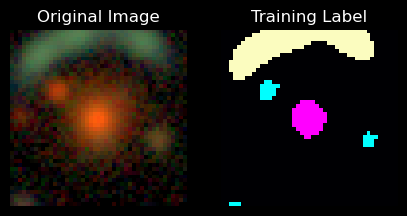

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


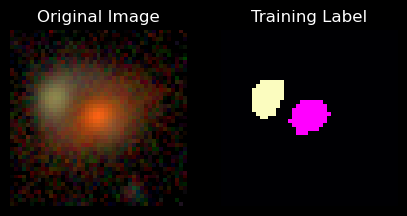

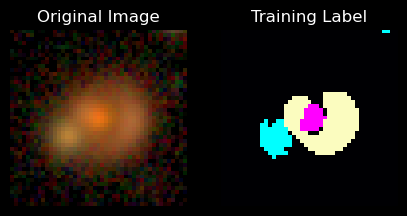

In [4]:
N = 3
for i in range(N):
    image = images[i]
    label = labels[i]
    show_training_sample(image, label)
    

In [5]:
N = 0
for i in range(len(labels)):
    label = labels[i]
    image = images[i]
    noise = label[2]
    binary = noise.astype(bool)
    # 4-connected (up/down/left/right): use ndi.generate_binary_structure(2, 1)
    # 8-connected (also diagonals):     use ndi.generate_binary_structure(2, 2)
    structure = ndi.generate_binary_structure(2, 2)  # 8-connected

    new_labels, n_blobs = ndi.label(binary, structure=structure)
    sizes = np.bincount(new_labels.ravel())[1:]   # skip label 0 = background

    if 1 in sizes and len(sizes) > 2:
        N += 1
        #show_training_sample(image, label)
    
print(N)


6223


In [6]:
# Pre-processing
N = 0
clean_labels = []
clean_images = []
clean_rows = []

for i in range(len(labels)):
    label = labels[i]
    image = images[i]
    data_row = data.iloc[i]
    noise = label[2]
    deflector = label[1]
    
    # Getting rid of 1 pixel Noise blobs
    binary = noise.astype(bool)
    structure = ndi.generate_binary_structure(2, 2)  # 8-connected, including diagonals, other: (2,1)
    new_labels, n_blobs = ndi.label(binary, structure=structure)
    sizes_all = np.bincount(new_labels.ravel())
    noise[sizes_all[new_labels] == 1] = 0
    
    # When there are 5 or more Noise blobs, remove all the blobs with size 3 pixels or smaller
    binary = noise.astype(bool)
    new_labels, _ = ndi.label(binary, structure=structure)
    sizes_all = np.bincount(new_labels.ravel())
    n_blobs = np.count_nonzero(sizes_all[1:])
    if n_blobs >= 5:
        noise[np.isin(sizes_all[new_labels], [2, 3])] = 0
    label[2] = noise
    
    # Removing points with artifacts in the labeling (when the labeling super fails)
    binary = noise.astype(bool)
    new_labels, _ = ndi.label(binary, structure=structure)
    sizes_all = np.bincount(new_labels.ravel())
    n_blobs = np.count_nonzero(sizes_all[1:])
    
    #Same as before, but using the deflector mask
    binary = deflector.astype(bool)
    new_labels, _ = ndi.label(binary, structure=structure)
    sizes_all_def = np.bincount(new_labels.ravel())
    
    #Creating new-clean dataset 
    if not ((n_blobs > 0 and np.any(sizes_all[1:] > 230)) or np.any(sizes_all_def[1:] > 230)):
        clean_labels.append(label)
        clean_images.append(image)
        clean_rows.append(data.iloc[i])
    

    if n_blobs > 0 and np.any(sizes_all[1:] > 230):
        #print(sizes_all[1:])
        #show_training_sample(image, label)
        N += 1
        
    
print(N)


138


In [7]:
#Cross-checking pre-processing
images = clean_images 
labels = clean_labels
data = pd.DataFrame(clean_rows)
#print(data.columns)

N = 0
for i in range(len(labels)):
    label = labels[i]
    image = images[i]
    noise = label[2]
    deflector = label[1]
    data_row = data.iloc[i]
    
    binary = noise.astype(bool)
    structure = ndi.generate_binary_structure(2, 2)  # 8-connected
    new_labels, n_blobs = ndi.label(binary, structure=structure)
    sizes_all = np.bincount(new_labels.ravel())  # skip label 0 = background
    n_blobs = np.count_nonzero(sizes_all[1:])
    
    if n_blobs == 0:
        #print(sizes_all[1:])
        #show_training_sample(image, label)
        N += 1
    
print(N)


15667


In [8]:
print(len(images), len(labels), len(data))



39785 39785 39785
